# Processing the dataset and preparing the environment for fine-tuning

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy

from PIL import Image

import random

import time

def create_df(path):
    dd = {"images": [], "labels": []}
    for i in os.listdir(path):
        img_dir = os.path.join(path, i)
        index = 0
        imgs = os.listdir(img_dir)
        random.shuffle(imgs)
        for j in imgs:
            dd["images"] += [os.path.join(img_dir, j)]
            dd["labels"] += [i]
            index += 1
            if index == 1341:
                break

    return pd.DataFrame(dd)

train = create_df("/kaggle/input/pneumonia-radiography-dataset/Radiography/train")
val = create_df("/kaggle/input/pneumonia-radiography-dataset/Radiography/val")
testing = create_df("/kaggle/input/pneumonia-radiography-dataset/Radiography/test")

index_label = dict()
label_index = dict()

label_index = {"NORMAL": 0, "PNEUMONIA": 1}
index_label = {0: "NORMAL", 1: "PNEUMONIA"}

train["labels"] = train["labels"].map(label_index)
val["labels"] = val["labels"].map(label_index)
testing["labels"] = testing["labels"].map(label_index)

EPOCHS = 10
STEP = 10
LR = 0.1
GAMMA = 0.1
IMG_SIZE = 224
BATCH = 16
OUT_SIZE = len(index_label)

class Pipeline(Dataset):
    def __init__(self, data, transform):
        super(Pipeline, self).__init__()
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, x):
        
        img, label = self.data[x, 0], self.data[x, 1]

        img = Image.open(img).convert("RGB")
        img = np.array(img)

        img = self.transform(img)
        return img, label

transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train = train.values
val = val.values

test = testing.values

train_ds = Pipeline(train, transform)
val_ds = Pipeline(val, transform)

train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, OUT_SIZE)

class ResNet(nn.Module):
    def __init__(self, model):
        super(ResNet, self).__init__()
        self.model = model

    def forward(self, x):
        return nn.functional.softmax(self.model(x), dim=1)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = ResNet(resnet)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s]


# Fine-tuning ResNet50 - training and evaluation log

Epoch 1 train loss 0.024604915283581465 acc 0.9269202087994034 val loss 0.029564950615167618 acc 0.875
Epoch 2 train loss 0.021653281517832426 acc 0.9683072334079046 val loss 0.027800178155303 acc 0.8125
Epoch 3 train loss 0.02106554539545004 acc 0.977255779269202 val loss 0.033632196485996246 acc 0.75
Epoch 4 train loss 0.020786820864339625 acc 0.9832214765100671 val loss 0.0272478349506855 acc 0.875
Epoch 5 train loss 0.02018104006913418 acc 0.9917971662938105 val loss 0.021192923188209534 acc 1.0
Epoch 6 train loss 0.02009035686918553 acc 0.9944071588366891 val loss 0.03010072372853756 acc 0.8125
Epoch 7 train loss 0.01998657537075586 acc 0.9947800149142431 val loss 0.02114623598754406 acc 1.0
Epoch 8 train loss 0.0198390759655471 acc 0.9973900074571216 val loss 0.03955886512994766 acc 0.625
Epoch 9 train loss 0.019719306432338546 acc 0.9992542878448919 val loss 0.024086695164442062 acc 0.9375
Epoch 10 train loss 0.019725161710841543 acc 0.9985085756897838 val loss 0.021534271538257

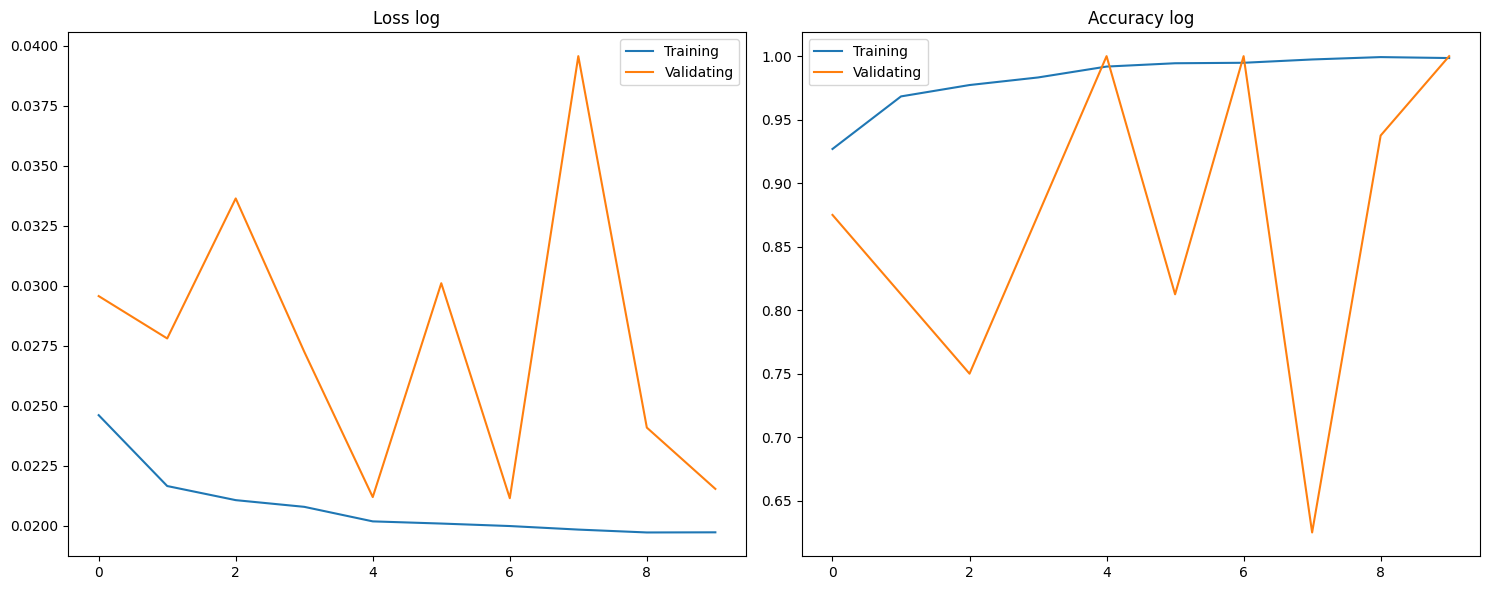

In [3]:
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for i in range(1, EPOCHS+1):
    model.train()

    diff = 0
    acc = 0
    total = 0

    for data, target in train_dl:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        out = model(data)
        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)

        loss.backward()
        optimizer.step()

    train_loss += [diff/total]
    train_acc += [acc/total]

    model.eval()

    diff = 0
    acc = 0
    total = 0

    with torch.no_grad():
        for data, target in val_dl:
            optimizer.zero_grad()
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)

    val_loss += [diff/total]
    val_acc += [acc/total]

    if val_acc[-1] >= best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)

    scheduler.step()

    print("Epoch {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1], train_acc[-1],
                                                                   val_loss[-1], val_acc[-1]))

fig, axes = plt.subplots(ncols=2, figsize=(15, 6))

index = 0

axes[index].plot(train_loss, label="Training")
axes[index].plot(val_loss, label="Validating")
axes[index].set_title("Loss log")
axes[index].legend()

index += 1

axes[index].plot(train_acc, label="Training")
axes[index].plot(val_acc, label="Validating")
axes[index].set_title("Accuracy log")
axes[index].legend()
plt.tight_layout()
plt.show()

# Evaluating fine-tuned ResNet50

              precision    recall  f1-score   support

           0       0.79      0.99      0.88       187
           1       0.99      0.84      0.91       298

    accuracy                           0.89       485
   macro avg       0.89      0.91      0.89       485
weighted avg       0.91      0.89      0.90       485



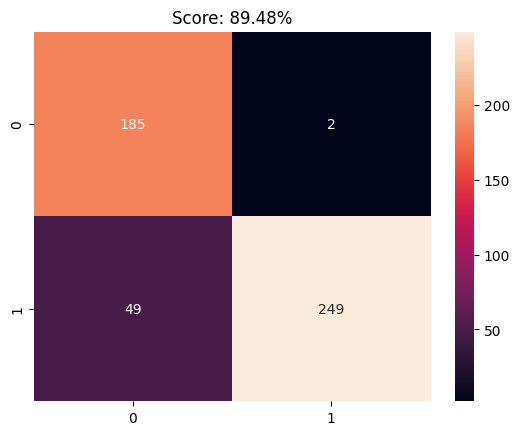

In [4]:
def predict(img):
    img = Image.open(img).convert("RGB")
    img = transform(np.array(img))
    img = img.view([1, 3, 224, 224])

    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()
        out = best_model(img)

    index = out.argmax(1).item()

    return index, round(out[0][index].item()*100, 2)

truth = []
preds = []
probas = []

for i in range(test.shape[0]):
    truth += [test[i, 1]]
    pred, proba = predict(test[i, 0])
    preds += [pred]
    probas += [proba]

score = accuracy_score(preds, truth)
print(classification_report(preds, truth))
sns.heatmap(confusion_matrix(preds, truth), annot=True, fmt='d')
plt.title("Score: {}%".format(round(score*100, 2)))
plt.show()